# Distributed GAN training demo - Generate celebrity faces

This notebook demonstrates how to use our pre-trained DCGAN model to generate realistic celebrity faces.

**What you'll do:**
- Load a pre-trained DCGAN model from Hugging Face
- Generate random celebrity faces
- Experiment with different random seeds
- Compare with real CelebA images (optional)

**No training required!** The model is already trained and ready to use.

**Note:** Image quality depends on how much the model has been trained. Early in training, you may see grey or noisy images. As training progresses with more workers contributing, the generated faces will become increasingly realistic.

## 1. Import required libraries

In [1]:
import sys
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import yaml
from huggingface_hub import hf_hub_download

# Add src to path
sys.path.insert(0, '../src')

from models.dcgan import Generator

# Set plotting style
plt.style.use('default')
%matplotlib inline

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

PyTorch version: 2.10.0+cu126
CUDA available: True
GPU: Tesla P100-PCIE-16GB


## 2. Load configuration

Load settings from config.yaml - this makes the notebook automatically use your project's Hugging Face repository.

In [2]:
# Load configuration from config.yaml
config_path = Path('../config.yaml')

if not config_path.exists():
    raise FileNotFoundError(
        'config.yaml not found! Make sure you are running this notebook from the notebooks/ directory.'
    )

with open(config_path) as f:
    config = yaml.safe_load(f)

# Model configuration
LATENT_DIM = config['training']['latent_dim']
IMAGE_SIZE = config['training']['image_size']
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hugging Face model settings from config
hf_config = config.get('huggingface', {})
HF_REPO_ID = hf_config.get('repo_id', '')
MODEL_FILENAME = 'checkpoint_latest.pth'

print(f'Configuration loaded from config.yaml')
print(f'  Device: {DEVICE}')
print(f'  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}')
print(f'  Latent dimension: {LATENT_DIM}')
print(f'  Hugging Face repo: {HF_REPO_ID}')

if not HF_REPO_ID:
    print('\nWarning: No Hugging Face repo configured in config.yaml')
    print('   Update the huggingface section in config.yaml with your repo details.')

Configuration loaded from config.yaml
  Device: cuda
  Image size: 64x64
  Latent dimension: 100
  Hugging Face repo: gperdrizet/GANNs-with-friends


## 3. Download pre-trained model

Download the trained generator model from Hugging Face Hub. This only needs to happen once - the model will be cached locally.

The model is automatically downloaded from the repository specified in your config.yaml file.

In [3]:
# Check if HF repo is configured
if not HF_REPO_ID:
    print('No Hugging Face repository configured!')
    print('\nTo use this notebook, you need to:')
    print('  1. Train a model (or have access to a trained model)')
    print('  2. Update config.yaml with your Hugging Face repo details:')
    print('     huggingface:')
    print('       enabled: true')
    print('       repo_id: your-username/your-repo')
    print('  3. Make sure the model has been uploaded to Hugging Face')
    raise ValueError('Hugging Face repo_id not configured in config.yaml')

# Create models directory if it does not exist
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Path where model will be saved
model_path = models_dir / MODEL_FILENAME

# Download from Hugging Face or use local copy
try:
    if not model_path.exists():
        print(f'Downloading model from Hugging Face: {HF_REPO_ID}...')
        downloaded_path = hf_hub_download(
            repo_id=HF_REPO_ID,
            filename=MODEL_FILENAME,
            cache_dir=models_dir
        )
        print(f'Model downloaded to: {downloaded_path}')
        model_path = Path(downloaded_path)
    else:
        print(f'Using cached model: {model_path}')
    
    # Initialize generator
    generator = Generator(latent_dim=LATENT_DIM).to(DEVICE)
    
    # Load weights
    checkpoint = torch.load(model_path, map_location=DEVICE)
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict) and 'generator_state_dict' in checkpoint:
        generator.load_state_dict(checkpoint['generator_state_dict'])
    else:
        generator.load_state_dict(checkpoint)
    
    generator.eval()
    
    # Print model info
    num_params = sum(p.numel() for p in generator.parameters())
    print(f'\nGenerator loaded successfully!')
    print(f'  Parameters: {num_params:,}')
    print(f'  Input: {LATENT_DIM}D random noise')
    print(f'  Output: {IMAGE_SIZE}x{IMAGE_SIZE} RGB images')
    
except Exception as e:
    print(f'\nError loading model: {e}')
    print(f'\nTroubleshooting:')
    print(f'  Make sure your model has been uploaded to: {HF_REPO_ID}')
    print(f'  Verify the file is named: {MODEL_FILENAME}')
    print(f'  Check your Hugging Face token is valid')
    print(f'  Visit: https://huggingface.co/{HF_REPO_ID}')
    raise


Model downloaded to: ../models/models--gperdrizet--GANNs-with-friends/snapshots/d34e6e14670b9c29e87dcfd5992a55a301ed4e4c/checkpoint_latest.pth

Generator loaded successfully!
  Parameters: 3,576,704
  Input: 100D random noise
  Output: 64x64 RGB images


## 4. Generate celebrity faces

Generate random celebrity faces from the trained model. Each time you run this cell, you'll get different faces!

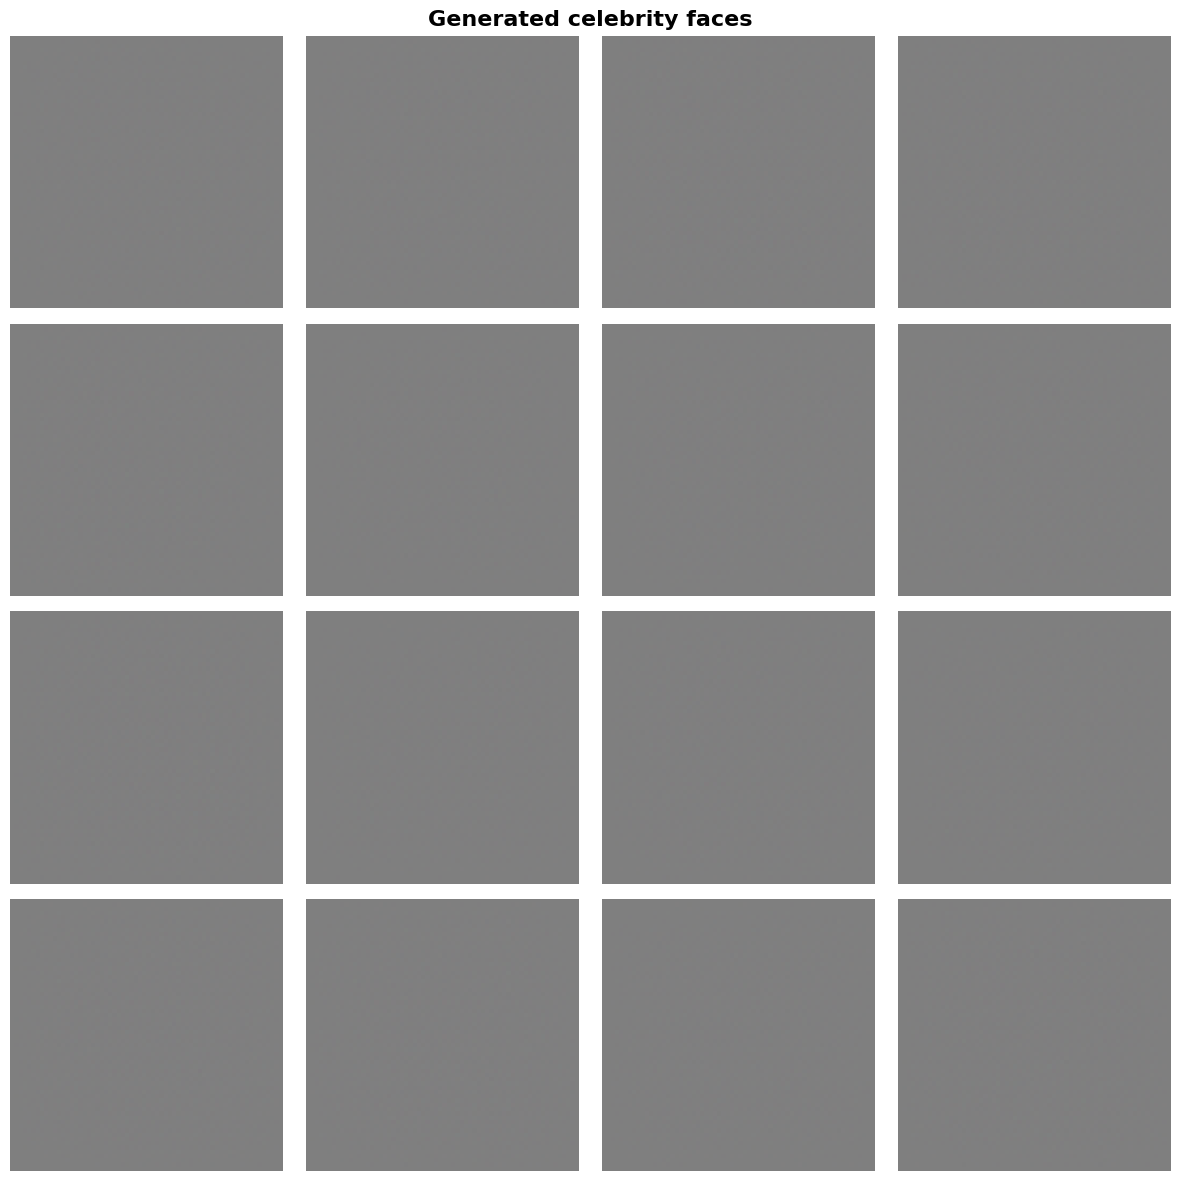

Generated 16 unique faces from random noise!

Tip: Run this cell multiple times to see different faces each time.


In [4]:
# Generate faces
num_samples = 16

with torch.no_grad():
    # Sample random noise from normal distribution
    noise = torch.randn(num_samples, LATENT_DIM, 1, 1, device=DEVICE)
    
    # Generate images
    generated_images = generator(noise).cpu()

# Display in a grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    # Convert from [-1, 1] to [0, 1] for display
    img = (generated_images[i].numpy() + 1) / 2
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Generated celebrity faces', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Generated {num_samples} unique faces from random noise!')
print(f'\nTip: Run this cell multiple times to see different faces each time.')


## 5. Reproducible generation with seeds

Use a random seed to generate the same faces consistently. Useful for debugging or creating consistent examples.

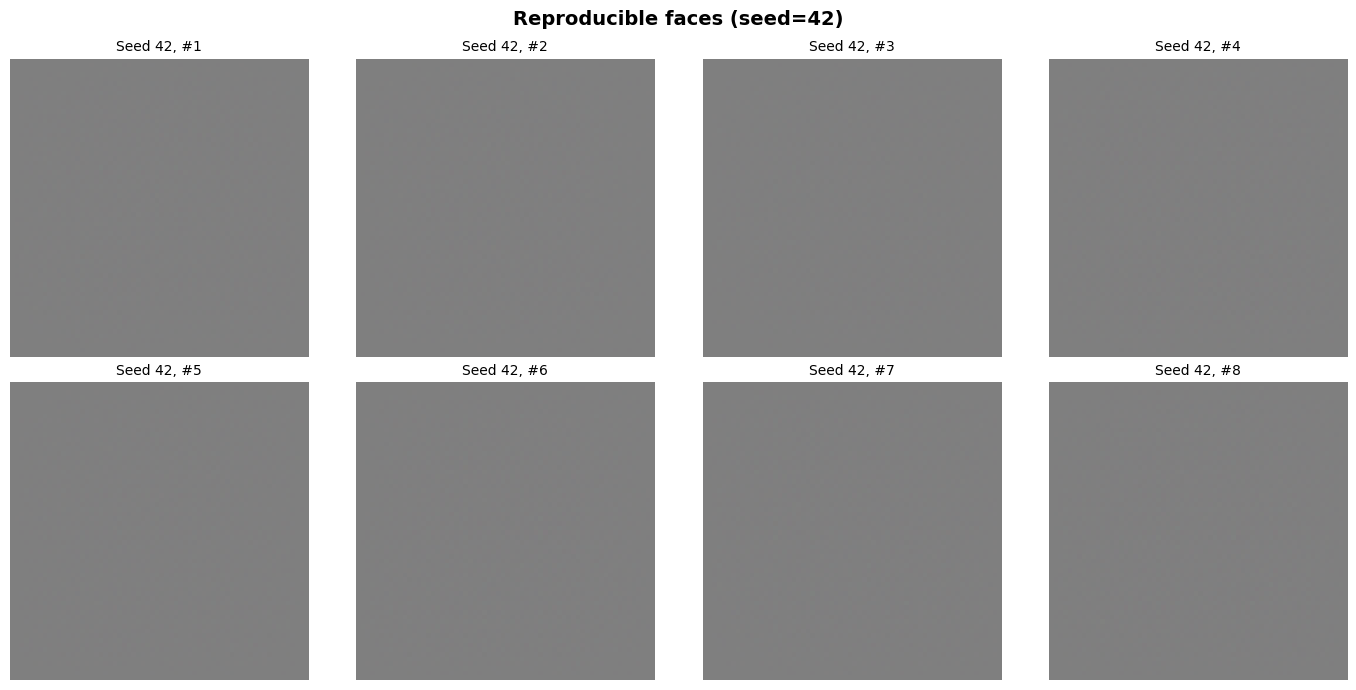

Generated with seed 42

These faces will be the same every time you run with this seed.
Change SEED to get different reproducible faces.


In [5]:
# Set seed for reproducibility
SEED = 42  # Change this to get different (but reproducible) faces
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

num_samples = 8

with torch.no_grad():
    noise = torch.randn(num_samples, LATENT_DIM, 1, 1, device=DEVICE)
    generated_images = generator(noise).cpu()

# Display
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for i, ax in enumerate(axes.flat):
    img = (generated_images[i].numpy() + 1) / 2
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(f'Seed {SEED}, #{i+1}', fontsize=10)
    ax.axis('off')

plt.suptitle(f'Reproducible faces (seed={SEED})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Generated with seed {SEED}')
print(f'\nThese faces will be the same every time you run with this seed.')
print(f'Change SEED to get different reproducible faces.')


## 6. Compare with real images

Loading dataset directly from zip: /workspaces/GANNs-with-friends/data/celeba_torchvision/data/img_align_celeba.zip
(No extraction needed - this saves disk I/O)
Loaded dataset with 202599 images
Dataset loaded: 202,599 images


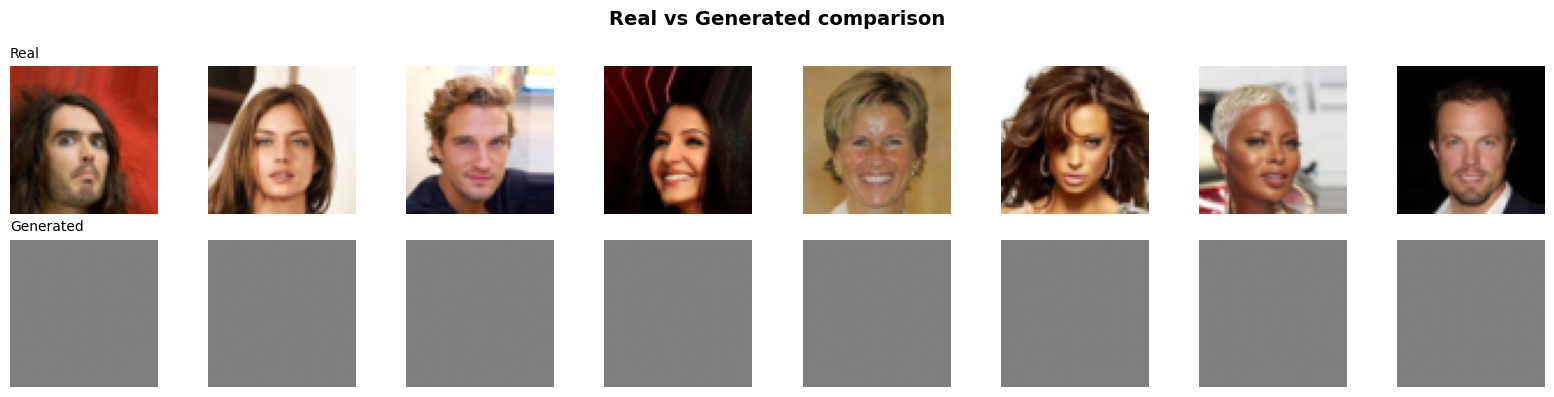

In [8]:
# Load dataset - resolve path relative to project root, not notebook directory
project_root = Path('../').resolve()
dataset_path = project_root / config['data']['dataset_path']

# CelebADataset automatically loads from zip file if folder doesn't exist
dataset = CelebADataset(str(dataset_path), image_size=IMAGE_SIZE)

print(f'Dataset loaded: {len(dataset):,} images')

# Sample random real images
num_samples = 8
np.random.seed(42)
indices = np.random.choice(len(dataset), num_samples, replace=False)

# Create comparison figure
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

# Top row: Real images
for i, idx in enumerate(indices):
    img, _ = dataset[idx]
    img = (img.numpy() + 1) / 2
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Real', fontsize=10, loc='left')

# Bottom row: Generated images
with torch.no_grad():
    noise = torch.randn(num_samples, LATENT_DIM, 1, 1, device=DEVICE)
    generated_images = generator(noise).cpu()

for i in range(num_samples):
    img = (generated_images[i].numpy() + 1) / 2
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Generated', fontsize=10, loc='left')

plt.suptitle('Real vs Generated comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Try it yourself!

Experiment with generating faces.

**Ideas**:
- Do similar latent space vectors result in similar faces?
- Can you automate finding the most 'convincing' faces?

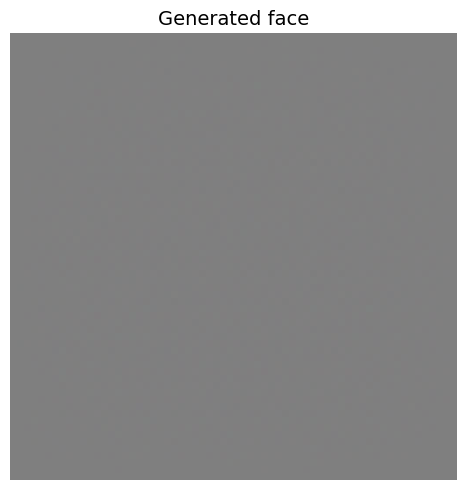

In [ ]:
# Example: Generate and save a single face
with torch.no_grad():
    noise = torch.randn(1, LATENT_DIM, 1, 1, device=DEVICE)
    face = generator(noise).cpu()

# Display
plt.figure(figsize=(5, 5))
img = (face[0].numpy() + 1) / 2
img = np.transpose(img, (1, 2, 0))
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Generated face', fontsize=14)
plt.tight_layout()
plt.show()

# To save: plt.imsave('my_generated_face.png', img)

---

## Summary

You have learned how to:
- Load a pre-trained DCGAN model from Hugging Face
- Generate random celebrity faces from noise
- Use seeds for reproducible generation
- Compare generated vs real images

### Next steps

Want to train your own model? Check out:
- `src/train_local.py` - Train on a single GPU
- `src/main.py` - Distributed training across multiple workers

### How the model works

The DCGAN (Deep Convolutional GAN) consists of:
- **Generator**: Transforms 100D random noise into 64x64 RGB images
- **Discriminator**: Distinguishes real from generated images

Through adversarial training, the generator learns to create realistic faces that fool the discriminator!
